In [1]:
import jieba
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import re
import collections

In [2]:
pip install jieba

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import datetime

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
#指定设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
training_file = 'fi.txt'

#读取text文件
def get_ch_lable(txt_file):  
    with open(txt_file, encoding='utf8') as f:
        text = f.readlines()
    return str(text)
training_data =get_ch_lable(training_file)

print("总字数",len(training_data))
print(training_data)

总字数 123316
['沪 指 开盘 报点 跌幅 \n', ' 深成指 报点 跌幅 创业板 指报 点 跌幅 中小板 指报 点 涨幅 \n', ' 盘面 上 计算机 领涨 交通运输 钢铁 公用事业 食品饮料 家用电器 等 板块 涨幅 居前 煤炭 领跌 石油 石化 通信建筑 装饰 国防 军工 房地产 等 走 弱 \n', ' 消息 面上 郑栅洁 表示 营造 市场化 法治化 国际化 的 一流 营商 环境 刘昆 表示 中国 将 坚持 推进 投资 便利化 贸易 自由化 公募 试点 再 扩容 消费 基础设施 非住宅 开发 项目 主板 注册 制 新股 今起 申购 打破 倍 市盈率 上限 月 中 上旬 有望 上市 滴灌 通 澳门 交易所 试营业 交易 的 是 什么 港交所 公布 新规 无 收益 特专 科技 公司 可提 上市 申请 期货 公司 监督管理 办法 征求意见 业务 准入 门槛 提高 下降 起 北京 种植 牙 价格 大幅 降低 \n', ' 隔夜 国际 市场动态 上周五 道 指涨 点 涨幅 为 报点 纳指 涨点 涨幅 为 报点 标普 指数 涨点 涨幅 为 报点 纽约商品交易所 原油 市场 月 交割 的 西 德克萨斯 中质 原油期货 价格 下跌 美分 或 收于 每桶 美元 纽约商品交易所 月 交割 的 黄金 期货价格 下跌 美元 跌幅 为 收于 每盎司 美元 \n', ' 登康 口腔 申购 代码 中重 科技 申购 代码 \n', ' 沪 指 开盘 报点 跌幅 \n', ' 深成指 报点 跌幅 创业板 指报 点 跌幅 中小板 指报 点 跌幅 \n', ' 盘面 上 有色金属 领涨 传媒 纺织 服饰 环保 国防 军工 美容 护理 等 板块 涨幅 居前 食品饮料 领跌 非银 金融 社会 服务 商贸 零售 建筑材料 计算机 等 走 弱 破产\n', ' 消息 面上 人民银行 银 保监会 称 银行 要 按 合同 约定 做好 客户 提前 还款 服务 工作 住 建部 首次 建议 试点 现房 销售 多地 跟进 推动 国家 发改委 表示 将 进一步 优化 石化 新能源 汽车 等 重大 生产力 布局 商务部 称 将 洛克希德 · 马丁 公司 雷神 导弹 与 防务 公司 列入 不 可靠 实体 清单 月 全国 新房 价格 出现 止跌 迹象 二手 住宅 市场 仍 在 寻底 南宁 楼盘 百岁 贷 火速 

In [7]:
#jieba分词
def fenci(training_data):
    seg_list = jieba.cut(training_data)  # 默认是精确模式  
    ci = " ".join(seg_list)
    ci = ci.split()
    #以空格将字符串分开
    training_ci = np.array(ci)
    training_ci = np.reshape(training_ci, [-1, ])
    return training_ci
training_ci =fenci(training_data)
print("总词数",len(training_ci))
print(training_ci)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.621 seconds.
Prefix dict has been built successfully.


总词数 44417
['[' "'" '沪' ... '涨幅' "'" ']']


In [8]:
def build_dataset(words, n_words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  
  return data, count, dictionary, reversed_dictionary

training_label, count, dictionary, words = build_dataset(training_ci, 189090)

In [9]:
#计算词频
word_count = np.array([freq for _,freq in count], dtype=np.float32)
word_freq = word_count / np.sum(word_count)#计算每个词的词频
word_freq = word_freq ** (3. / 4.)#词频变换
words_size = len(dictionary)
print("字典词数",words_size) 
print('Sample data', training_label[:10], [words[i] for i in training_label[:10]])

字典词数 4782
Sample data [2381, 1, 19, 18, 149, 16, 8, 3, 4, 1] ['[', "'", '沪', '指', '开盘', '报点', '跌幅', '\\', 'n', "'"]


In [10]:
C = 3 
num_sampled = 64  # 负采样个数   
BATCH_SIZE = 32  
EMBEDDING_SIZE = 32  #想要的词向量长度

class SkipGramDataset(Dataset):
    def __init__(self, training_label, word_to_idx, idx_to_word, word_freqs):
        super(SkipGramDataset, self).__init__()
        self.text_encoded = torch.Tensor(training_label).long()
        self.word_to_idx = word_to_idx
        self.idx_to_word = idx_to_word
        self.word_freqs = torch.Tensor(word_freqs)

    def __len__(self):
        return len(self.text_encoded)

    def __getitem__(self, idx):
        idx = min( max(idx,C),len(self.text_encoded)-2-C)#防止越界
        center_word = self.text_encoded[idx]
        pos_indices = list(range(idx-C, idx)) + list(range(idx+1, idx+1+C))
        pos_words = self.text_encoded[pos_indices] 
        #多项式分布采样，取出指定个数的高频词
        neg_words = torch.multinomial(self.word_freqs, num_sampled+2*C, False)#True)
        #去掉正向标签
        neg_words = torch.Tensor(np.setdiff1d(neg_words.numpy(),pos_words.numpy())[:num_sampled]).long()
        return center_word, pos_words, neg_words


print('制作数据集...')
train_dataset = SkipGramDataset(training_label, dictionary, words, word_freq)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,drop_last=True, shuffle=True)

制作数据集...


In [11]:
#将数据集转化成迭代器
sample = iter(dataloader)	
#从迭代器中取出一批次样本				
center_word, pos_words, neg_words = sample.__next__()				
print(center_word[0],words[np.compat.long(center_word[0])],[words[i] for i in pos_words[0].numpy()])

tensor(2038) 结合 ['在', '回调', '后', '行业', '公司', '披露']


In [12]:
class Model(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Model, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        initrange = 0.5 / self.embed_size
        self.in_embed = nn.Embedding(self.vocab_size, self.embed_size, sparse=False)
        self.in_embed.weight.data.uniform_(-initrange, initrange)

    def forward(self, input_labels, pos_labels, neg_labels):
        input_embedding = self.in_embed(input_labels)
                
        pos_embedding = self.in_embed(pos_labels)
        neg_embedding = self.in_embed(neg_labels)
        
        log_pos = torch.bmm(pos_embedding, input_embedding.unsqueeze(2)).squeeze()
        log_neg = torch.bmm(neg_embedding, -input_embedding.unsqueeze(2)).squeeze()

        log_pos = F.logsigmoid(log_pos).sum(1)
        log_neg = F.logsigmoid(log_neg).sum(1)
        loss = log_pos + log_neg
        return -loss

In [13]:
model = Model(words_size, EMBEDDING_SIZE).to(device)
model.train()

valid_size = 32
valid_window = words_size/2  # 取样数据的分布范围.
valid_examples = np.random.choice(int(valid_window), valid_size, replace=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCHS = 10

In [14]:
start = datetime.datetime.now()

In [15]:
for e in range(NUM_EPOCHS):
    for ei, (input_labels, pos_labels, neg_labels) in enumerate(dataloader):
        input_labels = input_labels.to(device)
        pos_labels = pos_labels.to(device)
        neg_labels = neg_labels.to(device)

        optimizer.zero_grad()
        loss = model(input_labels, pos_labels, neg_labels).mean()
        loss.backward()
        optimizer.step()

        if ei % 20 == 0:
            print("epoch: {}, iter: {}, loss: {}".format(e, ei, loss.item()))
    if e %40 == 0:           
        norm = torch.sum(model.in_embed.weight.data.pow(2),-1).sqrt().unsqueeze(1)
        normalized_embeddings = model.in_embed.weight.data / norm
        valid_embeddings = normalized_embeddings[valid_examples]
        
        similarity = torch.mm(valid_embeddings, normalized_embeddings.T)

epoch: 0, iter: 0, loss: 48.52109146118164
epoch: 0, iter: 20, loss: 48.51812744140625
epoch: 0, iter: 40, loss: 48.50210189819336
epoch: 0, iter: 60, loss: 48.5035285949707
epoch: 0, iter: 80, loss: 48.423248291015625
epoch: 0, iter: 100, loss: 48.388938903808594
epoch: 0, iter: 120, loss: 48.32266616821289
epoch: 0, iter: 140, loss: 48.333984375
epoch: 0, iter: 160, loss: 48.37327194213867
epoch: 0, iter: 180, loss: 48.15961837768555
epoch: 0, iter: 200, loss: 48.27034378051758
epoch: 0, iter: 220, loss: 47.216407775878906
epoch: 0, iter: 240, loss: 48.07196044921875
epoch: 0, iter: 260, loss: 47.662269592285156
epoch: 0, iter: 280, loss: 47.96603012084961
epoch: 0, iter: 300, loss: 48.55823516845703
epoch: 0, iter: 320, loss: 48.16426086425781
epoch: 0, iter: 340, loss: 47.86969757080078
epoch: 0, iter: 360, loss: 48.09736633300781
epoch: 0, iter: 380, loss: 47.84794616699219
epoch: 0, iter: 400, loss: 47.5914421081543
epoch: 0, iter: 420, loss: 47.48188018798828
epoch: 0, iter: 440

epoch: 2, iter: 840, loss: 47.69417190551758
epoch: 2, iter: 860, loss: 43.19853210449219
epoch: 2, iter: 880, loss: 47.93214797973633
epoch: 2, iter: 900, loss: 46.13025665283203
epoch: 2, iter: 920, loss: 46.476932525634766
epoch: 2, iter: 940, loss: 46.98040771484375
epoch: 2, iter: 960, loss: 46.695682525634766
epoch: 2, iter: 980, loss: 45.88896179199219
epoch: 2, iter: 1000, loss: 45.500911712646484
epoch: 2, iter: 1020, loss: 46.86252212524414
epoch: 2, iter: 1040, loss: 47.180572509765625
epoch: 2, iter: 1060, loss: 45.22983169555664
epoch: 2, iter: 1080, loss: 46.097469329833984
epoch: 2, iter: 1100, loss: 47.968788146972656
epoch: 2, iter: 1120, loss: 46.0440673828125
epoch: 2, iter: 1140, loss: 45.62528991699219
epoch: 2, iter: 1160, loss: 44.436241149902344
epoch: 2, iter: 1180, loss: 47.403045654296875
epoch: 2, iter: 1200, loss: 46.9386100769043
epoch: 2, iter: 1220, loss: 45.955814361572266
epoch: 2, iter: 1240, loss: 46.491493225097656
epoch: 2, iter: 1260, loss: 46.633

epoch: 5, iter: 260, loss: 44.75090026855469
epoch: 5, iter: 280, loss: 44.952613830566406
epoch: 5, iter: 300, loss: 44.28569412231445
epoch: 5, iter: 320, loss: 45.701622009277344
epoch: 5, iter: 340, loss: 46.15992736816406
epoch: 5, iter: 360, loss: 45.527217864990234
epoch: 5, iter: 380, loss: 45.30289840698242
epoch: 5, iter: 400, loss: 46.27531051635742
epoch: 5, iter: 420, loss: 44.87714767456055
epoch: 5, iter: 440, loss: 43.09803771972656
epoch: 5, iter: 460, loss: 45.62253952026367
epoch: 5, iter: 480, loss: 46.26885223388672
epoch: 5, iter: 500, loss: 45.276390075683594
epoch: 5, iter: 520, loss: 43.2816162109375
epoch: 5, iter: 540, loss: 46.903968811035156
epoch: 5, iter: 560, loss: 46.09593200683594
epoch: 5, iter: 580, loss: 45.87089920043945
epoch: 5, iter: 600, loss: 47.10450744628906
epoch: 5, iter: 620, loss: 45.83489990234375
epoch: 5, iter: 640, loss: 43.863739013671875
epoch: 5, iter: 660, loss: 45.979305267333984
epoch: 5, iter: 680, loss: 46.18417739868164
epoc

epoch: 7, iter: 1080, loss: 44.66486740112305
epoch: 7, iter: 1100, loss: 43.91339111328125
epoch: 7, iter: 1120, loss: 45.242820739746094
epoch: 7, iter: 1140, loss: 47.2397346496582
epoch: 7, iter: 1160, loss: 43.86067199707031
epoch: 7, iter: 1180, loss: 42.0948486328125
epoch: 7, iter: 1200, loss: 45.32368469238281
epoch: 7, iter: 1220, loss: 43.13865280151367
epoch: 7, iter: 1240, loss: 46.10093688964844
epoch: 7, iter: 1260, loss: 46.644927978515625
epoch: 7, iter: 1280, loss: 45.709930419921875
epoch: 7, iter: 1300, loss: 48.047698974609375
epoch: 7, iter: 1320, loss: 46.28144836425781
epoch: 7, iter: 1340, loss: 44.04083251953125
epoch: 7, iter: 1360, loss: 45.90385437011719
epoch: 7, iter: 1380, loss: 44.812278747558594
epoch: 8, iter: 0, loss: 47.825286865234375
epoch: 8, iter: 20, loss: 48.22072982788086
epoch: 8, iter: 40, loss: 43.97377014160156
epoch: 8, iter: 60, loss: 46.09514236450195
epoch: 8, iter: 80, loss: 45.5063591003418
epoch: 8, iter: 100, loss: 46.699172973632

In [16]:
end = datetime.datetime.now()
print('The total training time for skip-gram is:')
print(end - start)

The total training time for skip-gram is:
0:03:46.627323


In [17]:
for i in range(valid_size):
        valid_word = words[valid_examples[i]]
        top_k = 8  # 取最近的排名前8的词
        nearest = (-similarity[i, :]).argsort()[1:top_k + 1]  #argsort函数返回的是数组值从小到大的索引值
        log_str = 'Nearest to %s:' % valid_word  
        for k in range(top_k):
            close_word = words[nearest[k].cpu().item()]
            log_str = '%s,%s' % (log_str, close_word)
        print(log_str)

Nearest to 同期:,不及,腾讯,陡然,工信部,涨价,暂未,关于,打开
Nearest to 地方:,库存,两轮,转好,组织,投入,相继,定点,委员
Nearest to 拥挤:,本次,拟,关联度,评估,股东,美元汇率,独角兽,促使
Nearest to 天孚:,拓新,调动,解除,失败,认知,南方,望,前近
Nearest to 缓解:,有静待,难以,并未,报告,汇率,促使,据,城
Nearest to 放宽:,出让金,入境,国务院,洛克希德,电池,官员,新低,生效
Nearest to 可靠:,所致,税务总局,微,财富,引,相继,生产总值,发布公告
Nearest to 家电:,稳步,服务业,权重,而,货基,即,基建,连
Nearest to 医疗保健:,检察机关,回摆,体内,集中,光通信,同益,毛利率,二级
Nearest to 降:,并,统筹,减弱,还会,北京市,终端,激活,上游
Nearest to 注意:,抓手,优势产业,两年,工信部,强光,补贴,目标,通信软件
Nearest to 一方面:,重估,此外,困境,端,目前,各种,技术,一些
Nearest to 德克萨斯:,西,中质,原油期货,价格,白银,伦敦,轻质,期货价格
Nearest to 季报:,情况,楼盘,涨价,电池,转化,类产品,四季度,赛意
Nearest to 发出:,变暖,较长,侯金龙,化石,增亿,及,通道,超过
Nearest to 跳水:,充分,晶升,白酒,达,增持,后,九芝堂,重组
Nearest to 很:,艾普涨,涨价,宏观调控,陡然,转化,十分,办法,洛克希德
Nearest to 亿人次:,扩,刺激,得到,月末,接触,对算力,引导,内在
Nearest to 欲:,天平,英特,邮轮,审慎,回应,泰,兑现,大力
Nearest to 万维:,董事会,推,减少,成,增,火爆,飞跌超,农业
Nearest to 盘:,一逆,十三个,本川,川宁,南方,全世界,制度,晶圆厂
Nearest to 副所长:,办法,流向,共,上线,强光,光,任务,危机
Nearest to 中交:,清单,筑顶,拉,平移,或会,回应,一带,脉冲
Nearest to 有利于:,本轮,名为,潮博汇,快速增长,突破性,资源优势,已,突然
Nearest to 议息:,兑现,险守元,来袭,二次,日益,沙

In [18]:
final_embeddings = normalized_embeddings
labels = words[110]
print(labels)
print(final_embeddings[10])

代码
tensor([ 0.0908,  0.2733, -0.4941,  0.0009, -0.1906, -0.1159,  0.0388, -0.1895,
         0.0068,  0.2974, -0.0980,  0.0034, -0.0057, -0.0973, -0.2204, -0.3875,
        -0.0278,  0.0828, -0.2866, -0.0251,  0.0452, -0.1492, -0.0757,  0.0201,
        -0.1072,  0.0592, -0.0324,  0.0277,  0.2962, -0.0752,  0.0243,  0.2188])


In [19]:
len(words)

4782

In [20]:
with open('social-s.txt', 'a') as f:    
    for i in range(len(words)):
        f.write(words[i] + str(list(final_embeddings.numpy()[i])) + '\n')
f.close()
print('word vectors have written done.')

word vectors have written done.


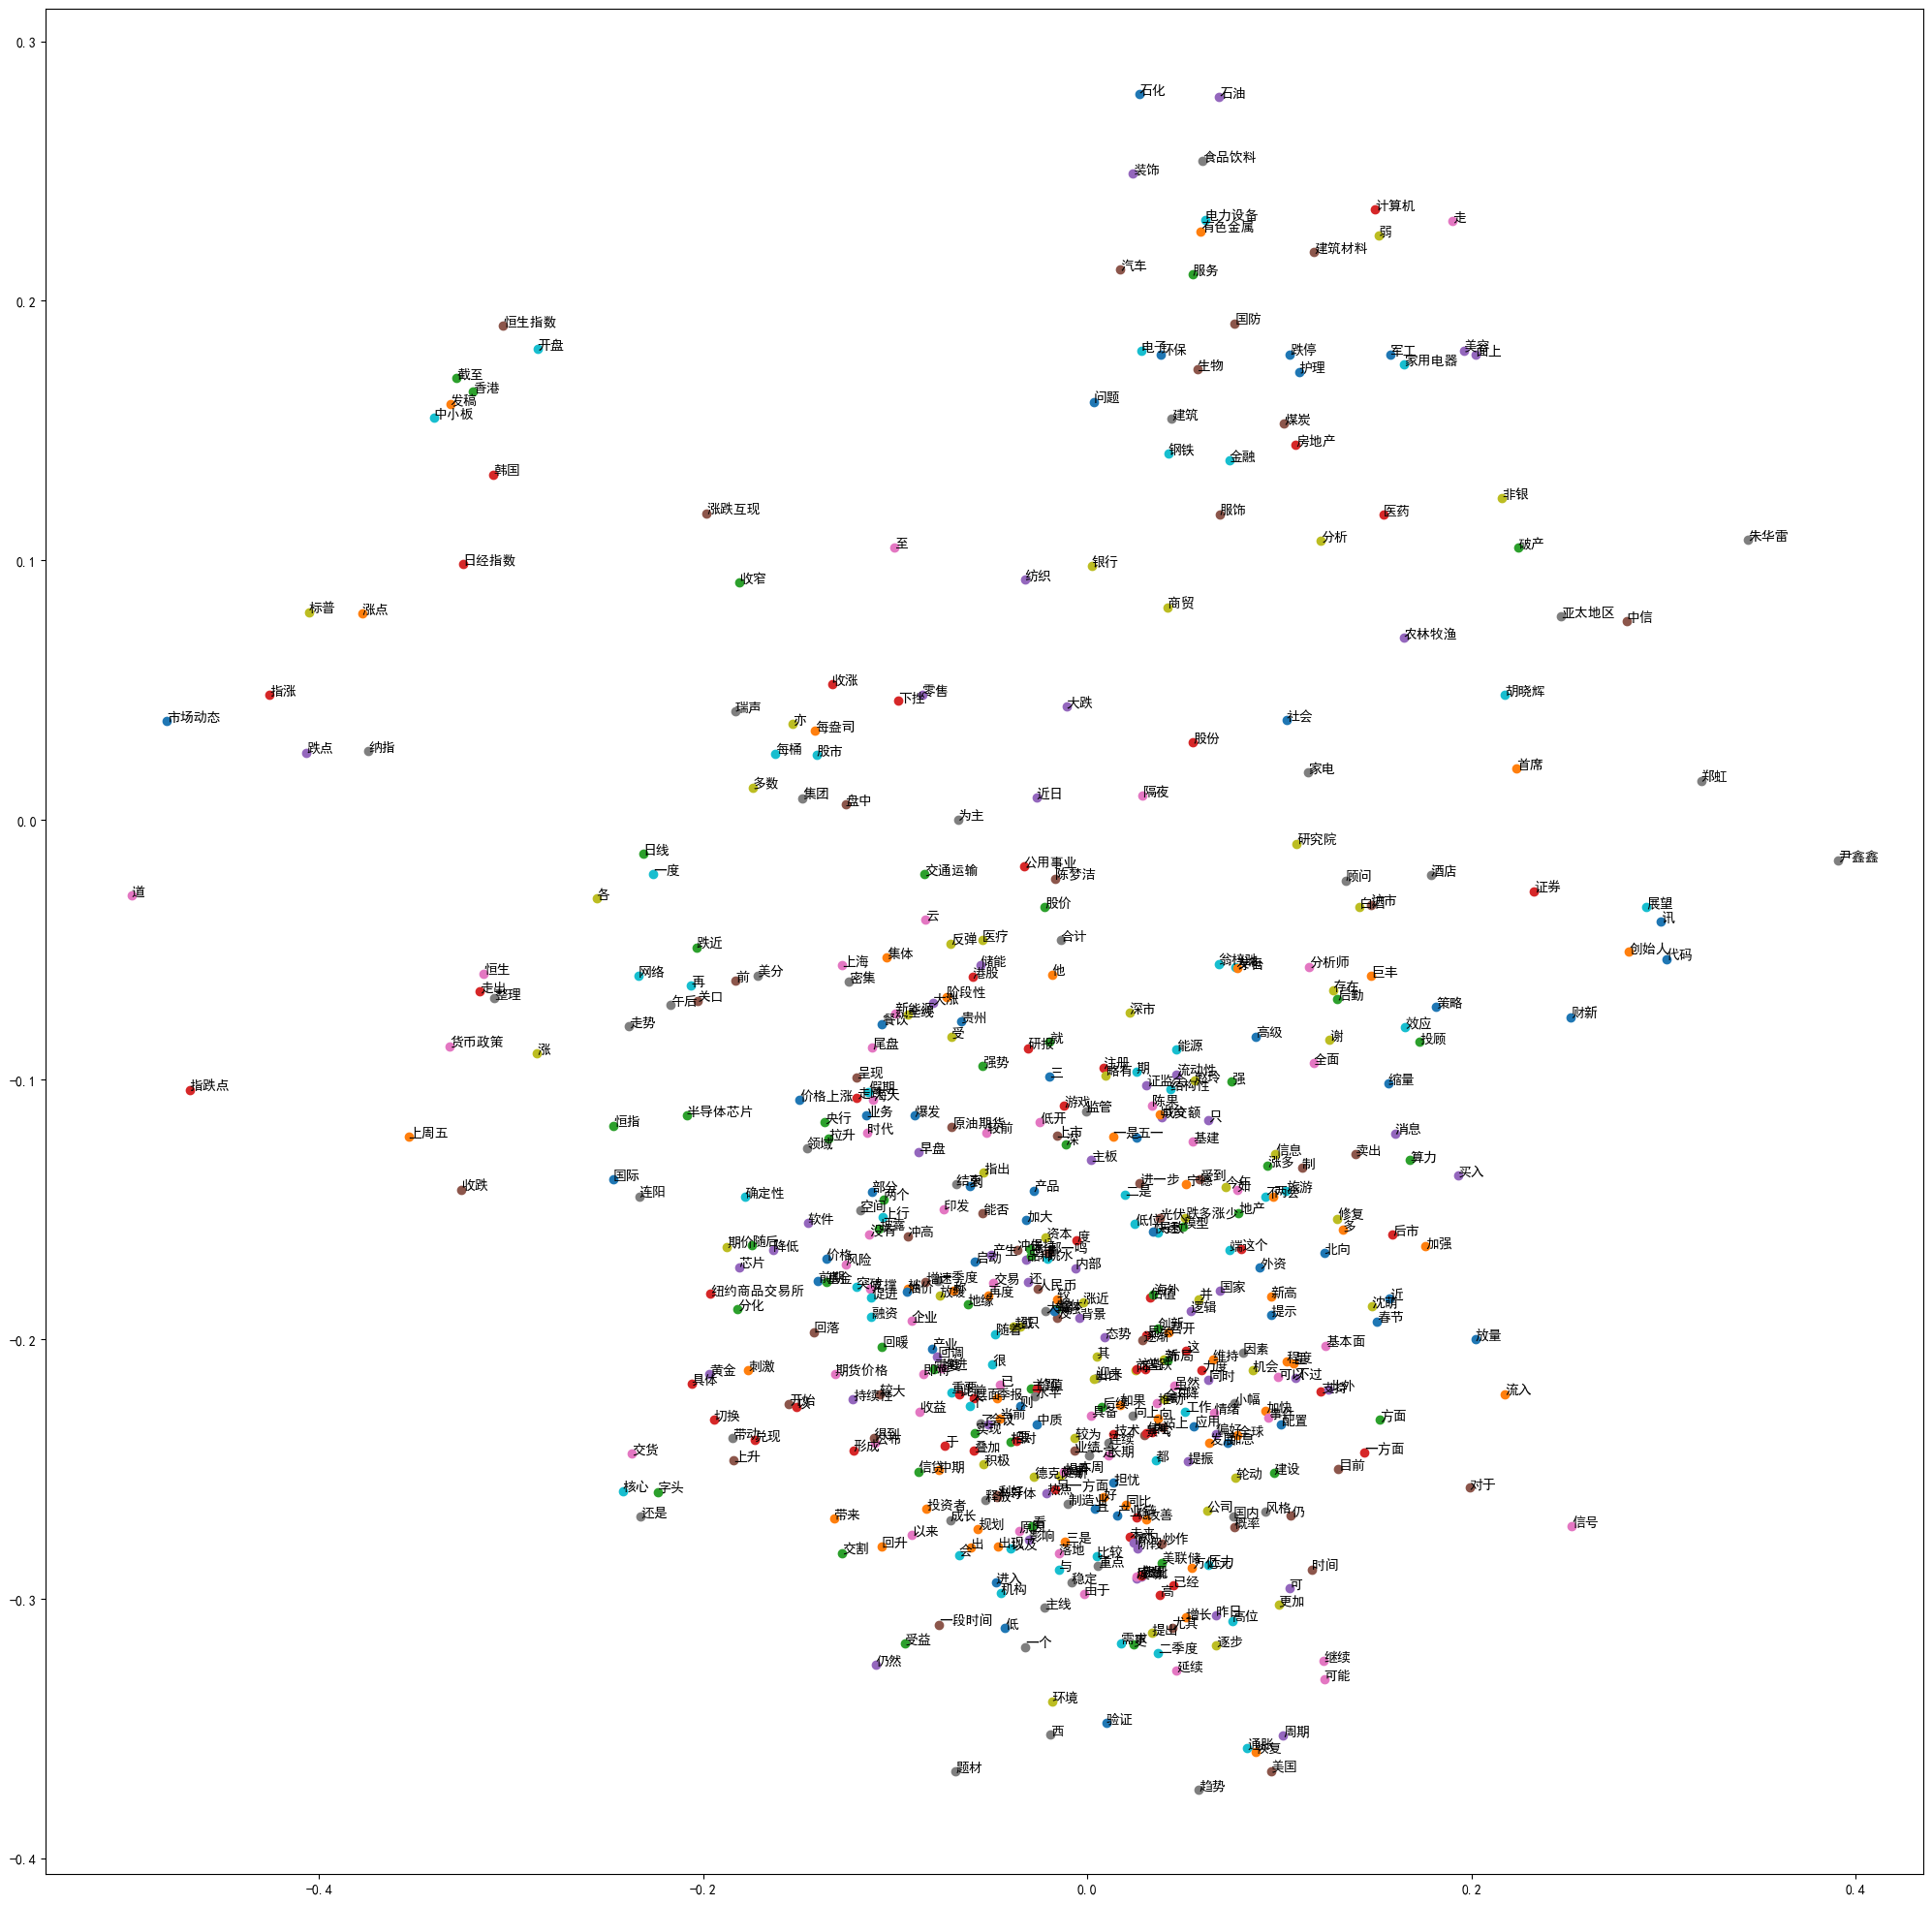

In [26]:
# 将词向量可视化
plt.figure(figsize=(25, 25))
# 只画出500个，太多显示效果很差
i = 100
while i < 600:
    plt.scatter(float(final_embeddings[i][0]), float(final_embeddings[i][1]))
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号，否则负号会显示成方块
    plt.annotate(words[i], (float(final_embeddings[i][0]), float(final_embeddings[i][1])))
    i += 1
plt.savefig('p3-s.png')
plt.show()

In [22]:
final_embeddings[500]

tensor([-0.1152, -0.1136,  0.0107,  0.2457, -0.1355, -0.0929,  0.2883,  0.0913,
        -0.2036, -0.1666, -0.2552, -0.1829, -0.1693,  0.0569, -0.0343, -0.1152,
         0.1531, -0.2016, -0.1428, -0.2528, -0.2070,  0.2873,  0.0925, -0.2918,
         0.1099,  0.0845,  0.2230, -0.0665, -0.3217,  0.1453,  0.1150,  0.0449])

In [23]:
a = len(words)
for i in range(a):
    if words[i] == '涨':
        print(i)

348


In [24]:
words[200]

'放量'